<a href="https://colab.research.google.com/github/undefinedzack/stock-market-prediction-using-sentiment-analysis/blob/master/Final_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data Manipulation

import numpy as np
import pandas as pd
import re

# Preprocessing the input data

import nltk
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Creating ngrams and vectorizing the data

from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser

# Tools for building a model

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
%cd drive/MyDrive/Colab_Data/
%ls -l

/content/drive/.shortcut-targets-by-id/1mnM1b6TaU1SW1anY35VRUPG3xIImlWjS/Colab_Data
total 474458
-rw------- 1 root root   2586020 Feb 20 13:52  200features_10minwords
-rw------- 1 root root 407958406 Feb 19 10:33  causeSheDidItThisWay.csv
-rw------- 1 root root    965379 Mar 31 16:44  df_final.csv
-rw------- 1 root root  34251814 Mar 31 11:47 'df_stocktwits_prepared_final (1).csv'
-rw------- 1 root root    512000 Apr  4 14:09 'df_stocktwits_prepared_final (2).csv'
-rw------- 1 root root  15257600 Mar 31 11:34  df_stocktwits_prepared_final.csv
-rw------- 1 root root     20844 Apr  6 16:46  final_data.csv
-rw------- 1 root root    133489 Apr  7 18:29  Final_Merged_Data.ipynb
-rw------- 1 root root   5617630 Mar 31 05:47  News.csv
drwx------ 2 root root      4096 Mar 19 13:58  saved_model/
-rw------- 1 root root   8086272 Apr  6 06:55  sentimenttweets.csv
-rw------- 1 root root       151 Apr  6 09:33  sentimenttweets.gsheet
-rw------- 1 root root     10892 Apr  6 09:54  sortedGroupedDates

In [ ]:
#dont run this file already made after getting sentiments from model..Goto the cell where its written 'RUN FROM HERE DIRECTLY' 
df1 = pd.read_csv('df_stocktwits_prepared_final (1).csv')
df2 = pd.read_csv('df_final.csv')

In [ ]:
df1=df1.iloc[:, 0:3]

In [ ]:
df1=df1.drop('time', axis=1)
df1['clean_text'] = df1.groupby(['created_date'])['clean_text'].transform(lambda x : ' '.join(x))
  
# drop duplicate data
df1 = df1.drop_duplicates()

In [ ]:
df1

,created_date,clean_text,sentiments
0,01-01-2019,thinking about buying a lot and hold it for lo...,0.995417
1,01-01-2019,So is it safe to say that the market bottomed ...,0.998086
2,01-01-2019,#NEVERFORGET,0.998789
3,01-01-2019,Helo where do you see going in the coming days...,0.002507
4,01-01-2019,ripping -9.83 % _url $BA,0.999294
...,...,...,...
77017,31-12-2019,260$in 2020 can not wait,0.999105
77018,31-12-2019,NEW ARTICLE : Year in Aerospace: Looking back ...,0.999919
77019,31-12-2019,Small portfolio proposal: AutoZone($AZO) Boein...,0.999992
77020,31-12-2019,Turkish Airlines says Boeing agrees to compens...,0.999867


In [ ]:
###### CLEANING EACH STRING
def clean(tweet :str) -> str:
  pat1= r'@[A-Za-z0-9]+'
  pat2= r'https?://[A-Za-z0-9./]+'
  combined_pat=r'|'.join((pat1,pat2))
  pat3= r'[^a-zA-Z]'
  combined_pat2=r'|'.join((combined_pat,pat3))
  
  # removing HTML
  text = BeautifulSoup(tweet, "lxml").get_text()

  # remove non-letters
  letters_only = re.sub(combined_pat2, " ", text)

  # converting to lower-case
  lowercase_letters = letters_only.lower()

  return lowercase_letters


##### LEMMATIZATION
def lemmatize(tokens :list) -> list:
  lemmatizer = WordNetLemmatizer()
  ps= PorterStemmer()
  stop_words = set(stopwords.words("english"))  
 
  # lemmatize
  lemmatized_tokens = list(map(lemmatizer.lemmatize, tokens))

  # remove stop words
  meaningful_words = list(filter(lambda x : x not in stop_words, lemmatized_tokens))

  tweets = [ps.stem(word) for word in meaningful_words]
  return tweets


###### ALL TOGETHER
def preprocess(tweet :str) -> list:

  # clean tweet
  clean_tweet = clean(tweet)

  # tokenize
  tokens = word_tokenize(clean_tweet)

  # lemmatize
  lemmaz = lemmatize(tokens)

  return lemmaz


###### CLEANING WHOLE DATA BY PROCESSING EACH TWEET ONE BY ONE
def get_clean_data(tweets):
  return np.array(list(map(preprocess, tweets )))

  
###### BUILDING TRIGRAMS MODEL
def build_trigrams_model(cleaned_data):
  #creating n grams
  bigrams = Phrases(sentences=cleaned_data)
  trigrams = Phrases(sentences=bigrams[cleaned_data])
  
  # creating trigram model
  embedding_vector_size = 256
  trigrams_model = Word2Vec(
      sentences = trigrams[bigrams[cleaned_data]],
      size = embedding_vector_size,
      min_count=3, window=5, workers=4)
  
  return trigrams_model


###### VECTORIZING DATA
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda tweet: list(map(keys.index, filter(filter_unknown, tweet)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized


###### FINAL DATA WITH PADDING
def vectorised_padded_data(cleaned_data):
  
  bigrams = Phrases(sentences=cleaned_data)
  trigrams = Phrases(sentences=bigrams[cleaned_data])
  X_data = trigrams[bigrams[cleaned_data]]
  
  print('Convert sentences to sentences with ngrams... (done)')
  input_length = 150
  
  trigrams_model = build_trigrams_model(cleaned_data)
  X_pad = pad_sequences(
      sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab),
      maxlen=input_length,
      padding='post')
  return X_pad


###### CLUBBING VECTORIZATION AND PADDING FUCTION
def suitable_data(tweets):
  cleaned_data = get_clean_data(tweets)
  return vectorised_padded_data(cleaned_data)
  



In [ ]:
X_pad = suitable_data(df1['clean_text'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Convert sentences to sentences with ngrams... (done)
Vectorize sentences...
Vectorize sentences... (done)


In [ ]:
lis = np.where(X_pad>10678)
for i in range(0,len(lis[0])):
  X_pad[lis[0][i]][lis[1][i]]=10678

In [ ]:
my_model = tf.keras.models.load_model('saved_model')

In [ ]:
outputs=my_model.predict(x=X_pad)

In [ ]:
df1=df1.drop('time', axis=1)
df1=df1.assign(sentiments = outputs)
df1

,created_date,clean_text,sentiments
0,01-01-2019,thinking about buying a lot and hold it for lo...,0.995417
1,01-01-2019,So is it safe to say that the market bottomed ...,0.998086
2,01-01-2019,#NEVERFORGET,0.998789
3,01-01-2019,Helo where do you see going in the coming days...,0.002507
4,01-01-2019,ripping -9.83 % _url $BA,0.999294
...,...,...,...
77017,31-12-2019,260$in 2020 can not wait,0.999105
77018,31-12-2019,NEW ARTICLE : Year in Aerospace: Looking back ...,0.999919
77019,31-12-2019,Small portfolio proposal: AutoZone($AZO) Boein...,0.999992
77020,31-12-2019,Turkish Airlines says Boeing agrees to compens...,0.999867


In [ ]:
#stored in sentimenttweets.csv
df1.to_csv("sentimenttweets.csv", index=False)

In [ ]:

df1=pd.read_csv('sentimenttweets.csv')
df2 = pd.read_csv('df_final.csv')

In [ ]:
df1['created_date'] = pd.to_datetime(df1['created_date'])
df1.sort_values(by='created_date')
df1

,created_date,clean_text,sentiments
0,2019-01-01,thinking about buying a lot and hold it for lo...,0.995417
1,2019-01-01,So is it safe to say that the market bottomed ...,0.998086
2,2019-01-01,#NEVERFORGET,0.998789
3,2019-01-01,Helo where do you see going in the coming days...,0.002507
4,2019-01-01,ripping -9.83 % _url $BA,0.999294
...,...,...,...
77017,2019-12-31,260$in 2020 can not wait,0.999105
77018,2019-12-31,NEW ARTICLE : Year in Aerospace: Looking back ...,0.999919
77019,2019-12-31,Small portfolio proposal: AutoZone($AZO) Boein...,0.999992
77020,2019-12-31,Turkish Airlines says Boeing agrees to compens...,0.999867


In [ ]:
#taking mean of sentiments for same date
df1 = df1.groupby(['created_date'],as_index=False).mean()    #as_index=False important so that there's a column of createddate too

In [ ]:
df1.head(10)

,created_date,sentiments
0,2019-01-01,0.772641
1,2019-01-02,0.886450
2,2019-01-03,0.900668
3,2019-01-04,0.897670
4,2019-01-05,0.916115
5,2019-01-06,0.897942
6,2019-01-07,0.930851
7,2019-01-08,0.919283
8,2019-01-09,0.923342
9,2019-01-10,0.957152


In [ ]:
#df1.to_csv("sortedGroupedDatesSentiments.csv", index=False)

In [ ]:
df2.head(10)

,Time,Open,High,Low,Close,Adj Close,Volume,bullish,volume_before_1,volume_diff_last_hour,volume_before_2,volume_diff_last_2_hour,volume_before_3,volume_diff_last_3_hour,volume_before_4,volume_diff_last_4_hour,volume_before_5,volume_diff_last_5_hour,close_before_1,close_diff_last_hour,close_before_2,close_diff_last_2_hour,close_before_3,close_diff_last_3_hour,close_before_4,close_diff_last_4_hour,close_before_5,close_diff_last_5_hour,close_before_6,close_diff_last_6_hour,close_before_7,close_diff_last_7_hour,close_before_8,close_diff_last_8_hour,close_before_9,close_diff_last_9_hour,SMA_15,SMA_30,SMA_indicator,SMA_indicator_before_1,SMA_indicator_before_2,SMA_indicator_before_3,SMA_indicator_before_4,Upper_Bollinger,Lower_Bollinger,Middle_Bollinger,close_diff_Upper_Bollinger,close_diff_Lower_Bollinger,Bollinger_indicator,Bollinger_indicator_before_1,Bollinger_indicator_before_2,Bollinger_indicator_before_3,Bollinger_indicator_before_4,true_range,holiday_day_diff_before,date,weekday,time,mean_sentiment_score,median_sentiment_score,std_sentiment_score,max_sentiment_score,min_sentiment_score
0,02-01-2019 09:30,315.500000,319.709992,313.899994,318.440002,318.440002,724286,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,318.440002,318.440002,0,NaN,NaN,NaN,NaN,NaN,NaN,318.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,2,2,1,0.132733,0.174651,0.190971,0.471599,-0.323868
1,02-01-2019 10:30,318.439301,322.307007,317.350006,320.520294,320.520294,394681,0.0,724286.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,318.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,319.480148,319.480148,0,0.0,NaN,NaN,NaN,322.422125,316.538171,319.480148,-1.901831,3.982123,2.0,NaN,NaN,NaN,NaN,4.957001,34,2,2,2,0.227726,0.227726,0.041528,0.257091,0.198361
2,02-01-2019 11:30,320.567505,321.658691,319.093506,319.547790,319.547790,250973,0.0,394681.0,-329605.0,724286.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320.520294,2.080292,318.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,319.502696,319.502696,0,0.0,0.0,NaN,NaN,321.584453,317.420938,319.502696,-2.036663,2.126852,2.0,2.0,NaN,NaN,NaN,2.565186,34,2,2,3,NaN,NaN,NaN,NaN,NaN
3,02-01-2019 12:30,319.798492,323.690002,319.250000,323.340790,323.340790,274696,0.0,250973.0,-143708.0,394681.0,-329605.0,724286.0,NaN,NaN,NaN,NaN,NaN,319.547790,-0.972504,320.520294,2.080292,318.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320.462219,320.462219,0,0.0,0.0,0.0,NaN,324.659851,316.264588,320.462219,-1.319061,7.076202,2.0,2.0,2.0,NaN,NaN,4.440002,34,2,2,4,NaN,NaN,NaN,NaN,NaN
4,02-01-2019 13:30,323.443207,323.790008,320.679993,321.760010,321.760010,265741,0.0,274696.0,23723.0,250973.0,-143708.0,394681.0,-329605.0,724286.0,NaN,NaN,NaN,323.340790,3.792999,319.547790,-0.972504,320.520294,2.080292,318.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320.721777,320.721777,0,0.0,0.0,0.0,0.0,324.537860,316.905694,320.721777,-2.777851,4.854315,2.0,2.0,2.0,2.0,NaN,3.110016,34,2,2,5,-0.176063,-0.176063,NaN,-0.176063,-0.176063
5,02-01-2019 14:30,322.000000,322.732300,319.529999,320.820007,320.820007,365267,0.0,265741.0,-8955.0,274696.0,23723.0,250973.0,-143708.0,394681.0,-329605.0,724286.0,NaN,321.760010,-1.580780,323.340790,3.792999,319.547790,-0.972504,320.520294,2.080292,318.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320.738149,320.738149,0,0.0,0.0,0.0,0.0,324.152300,317.323998,320.738149,-3.332292,3.496009,2.0,2.0,2.0,2.0,2.0,3.202301,34,2,2,6,0.008445,0.008445,0.173952,0.131448,-0.114558
6,02-01-2019 15:30,320.670013,323.850006,320.244385,323.839996,323.839996,360878,0.0,365267.0,99526.0,265741.0,-8955.0,274696.0,23723.0,250973.0,-143708.0,394681.0,-329605.0,320.820007,-0.940002,321.760010,-1.580780,323.340790,3.792999,319.547790,-0.972504,320.520294,2.080292,318.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,321.181270,321.181270,0,0.0,0.0,0.0,0.0,325.081483,317.281057,321.181270,-1.241487,6.558939,2.0,2.0,2.0,2.0,2.0,3.605621,34,2,2,7,0.167821

In [ ]:
#Extracting date from 'Time' Column for a new column 'created_date' 
df2['created_date'] = df2['Time'].transform(lambda x : x.split(' ')[0])

#Sorting According to Created_date
df2['created_date'] = pd.to_datetime(df2['created_date'])
df2.sort_values(by='created_date')
df2.head()


,Time,Open,High,Low,Close,Adj Close,Volume,bullish,volume_before_1,volume_diff_last_hour,volume_before_2,volume_diff_last_2_hour,volume_before_3,volume_diff_last_3_hour,volume_before_4,volume_diff_last_4_hour,volume_before_5,volume_diff_last_5_hour,close_before_1,close_diff_last_hour,close_before_2,close_diff_last_2_hour,close_before_3,close_diff_last_3_hour,close_before_4,close_diff_last_4_hour,close_before_5,close_diff_last_5_hour,close_before_6,close_diff_last_6_hour,close_before_7,close_diff_last_7_hour,close_before_8,close_diff_last_8_hour,close_before_9,close_diff_last_9_hour,SMA_15,SMA_30,SMA_indicator,SMA_indicator_before_1,SMA_indicator_before_2,SMA_indicator_before_3,SMA_indicator_before_4,Upper_Bollinger,Lower_Bollinger,Middle_Bollinger,close_diff_Upper_Bollinger,close_diff_Lower_Bollinger,Bollinger_indicator,Bollinger_indicator_before_1,Bollinger_indicator_before_2,Bollinger_indicator_before_3,Bollinger_indicator_before_4,true_range,holiday_day_diff_before,date,weekday,time,mean_sentiment_score,median_sentiment_score,std_sentiment_score,max_sentiment_score,min_sentiment_score,created_date
0,02-01-2019 09:30,315.500000,319.709992,313.899994,318.440002,318.440002,724286,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,318.440002,318.440002,0,NaN,NaN,NaN,NaN,NaN,NaN,318.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,2,2,1,0.132733,0.174651,0.190971,0.471599,-0.323868,2019-02-01
1,02-01-2019 10:30,318.439301,322.307007,317.350006,320.520294,320.520294,394681,0.0,724286.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,318.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,319.480148,319.480148,0,0.0,NaN,NaN,NaN,322.422125,316.538171,319.480148,-1.901831,3.982123,2.0,NaN,NaN,NaN,NaN,4.957001,34,2,2,2,0.227726,0.227726,0.041528,0.257091,0.198361,2019-02-01
2,02-01-2019 11:30,320.567505,321.658691,319.093506,319.547790,319.547790,250973,0.0,394681.0,-329605.0,724286.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320.520294,2.080292,318.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,319.502696,319.502696,0,0.0,0.0,NaN,NaN,321.584453,317.420938,319.502696,-2.036663,2.126852,2.0,2.0,NaN,NaN,NaN,2.565186,34,2,2,3,NaN,NaN,NaN,NaN,NaN,2019-02-01
3,02-01-2019 12:30,319.798492,323.690002,319.250000,323.340790,323.340790,274696,0.0,250973.0,-143708.0,394681.0,-329605.0,724286.0,NaN,NaN,NaN,NaN,NaN,319.547790,-0.972504,320.520294,2.080292,318.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320.462219,320.462219,0,0.0,0.0,0.0,NaN,324.659851,316.264588,320.462219,-1.319061,7.076202,2.0,2.0,2.0,NaN,NaN,4.440002,34,2,2,4,NaN,NaN,NaN,NaN,NaN,2019-02-01
4,02-01-2019 13:30,323.443207,323.790008,320.679993,321.760010,321.760010,265741,0.0,274696.0,23723.0,250973.0,-143708.0,394681.0,-329605.0,724286.0,NaN,NaN,NaN,323.340790,3.792999,319.547790,-0.972504,320.520294,2.080292,318.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320.721777,320.721777,0,0.0,0.0,0.0,0.0,324.537860,316.905694,320.721777,-2.777851,4.854315,2.0,2.0,2.0,2.0,NaN,3.110016,34,2,2,5,-0.176063,-0.176063,NaN,-0.176063,-0.176063,2019-02-01


In [ ]:
df2_open=df2[['created_date', 'Open']]
df2_close=df2[['created_date', 'Close']]
df2_open

,created_date,Open
0,2019-02-01,315.500000
1,2019-02-01,318.439301
2,2019-02-01,320.567505
3,2019-02-01,319.798492
4,2019-02-01,323.443207
...,...,...
1745,2019-12-30,327.744995
1746,2019-12-30,327.049988
1747,2019-12-30,327.269989
1748,2019-12-31,325.410004


In [ ]:
df2_close

,created_date,Close
0,02-01-2019,318.440002
1,02-01-2019,320.520294
2,02-01-2019,319.547790
3,02-01-2019,323.340790
4,02-01-2019,321.760010
...,...,...
1745,30-12-2019,327.059998
1746,30-12-2019,327.289612
1747,30-12-2019,326.540008
1748,31-12-2019,324.709992


In [ ]:
#Taking 1st entry of open value and last entry of close value for the date
df2_open = df2_open.groupby(['created_date']).first()
df2_close = df2_close.groupby(['created_date']).last()
df2_open

,Open
created_date,
2019-01-02,386.829987
2019-01-03,445.709992
2019-01-04,386.359985
2019-01-05,378.529999
2019-01-07,364.880005
...,...
2019-12-24,339.510010
2019-12-26,333.197388
2019-12-27,330.200012


In [ ]:
df2_close

,Close
created_date,
2019-01-02,387.399994
2019-01-03,440.910004
2019-01-04,391.540008
2019-01-05,376.700012
2019-01-07,356.029999
...,...
2019-12-24,332.500000
2019-12-26,329.920013
2019-12-27,330.119995


In [ ]:
final=pd.merge(df2_open,df2_close,on='created_date')

In [ ]:
final

,Open,Close
created_date,,
2019-01-02,386.829987,387.399994
2019-01-03,445.709992,440.910004
2019-01-04,386.359985,391.540008
2019-01-05,378.529999,376.700012
2019-01-07,364.880005,356.029999
...,...,...
2019-12-24,339.510010,332.500000
2019-12-26,333.197388,329.920013
2019-12-27,330.200012,330.119995


In [ ]:
#Some dates are misssing in close open dataset due to holiday..getting them in a list
missing_dates=pd.date_range(start = '2019-01-01', end = '2019-12-31' ).difference(final.index).tolist()
missing_dates

[Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-01-06 00:00:00'),
 Timestamp('2019-01-09 00:00:00'),
 Timestamp('2019-01-12 00:00:00'),
 Timestamp('2019-01-13 00:00:00'),
 Timestamp('2019-01-19 00:00:00'),
 Timestamp('2019-01-20 00:00:00'),
 Timestamp('2019-01-21 00:00:00'),
 Timestamp('2019-01-26 00:00:00'),
 Timestamp('2019-01-27 00:00:00'),
 Timestamp('2019-02-02 00:00:00'),
 Timestamp('2019-02-03 00:00:00'),
 Timestamp('2019-02-06 00:00:00'),
 Timestamp('2019-02-09 00:00:00'),
 Timestamp('2019-02-11 00:00:00'),
 Timestamp('2019-02-16 00:00:00'),
 Timestamp('2019-02-17 00:00:00'),
 Timestamp('2019-02-18 00:00:00'),
 Timestamp('2019-02-23 00:00:00'),
 Timestamp('2019-02-24 00:00:00'),
 Timestamp('2019-03-02 00:00:00'),
 Timestamp('2019-03-03 00:00:00'),
 Timestamp('2019-03-08 00:00:00'),
 Timestamp('2019-03-11 00:00:00'),
 Timestamp('2019-03-16 00:00:00'),
 Timestamp('2019-03-17 00:00:00'),
 Timestamp('2019-03-23 00:00:00'),
 Timestamp('2019-03-24 00:00:00'),
 Timestamp('2019-03-

In [ ]:
#Function to merge sentiments of a holiday with its previous day sentiment
def missDateMerge(df1):
  newSentiments=df1['sentiments'].tolist()
  for i in range(1, len(newSentiments)):
    lst=[]
    j=i-1
    if df1['created_date'][i] in missing_dates:
      #print(df1['created_date'][i])
      while df1['created_date'][j] in missing_dates:      #if previous day sentiments are also holidays
        lst.append(newSentiments[j])
        j=j-1
      lst.append(newSentiments[j])
      #print(lst)
      newSentiments[j]=(sum(lst)+newSentiments[i])/(len(lst)+1)   #taking avg of all holiday sentiments and asssigning it to previous day 
  return newSentiments


newSentiments=missDateMerge(df1)
newSentiments 

[0.77264065994,
 0.8864495920283344,
 0.9006677304969024,
 0.8976700394170924,
 0.9070285966607515,
 0.8979417914629998,
 0.9308511562769265,
 0.9213128095942498,
 0.9233421706257141,
 0.9571522419090912,
 0.9091290155317607,
 0.9294372661904762,
 0.8683207280922806,
 0.9075074216514286,
 0.9459511381250003,
 0.9637507043902438,
 0.878240524677309,
 0.8914636653310795,
 0.920780704357143,
 0.8456792482946667,
 0.9144440957142856,
 0.8854425124153334,
 0.8971037441503193,
 0.8700949727983867,
 0.9447989788368297,
 0.9577430795238097,
 0.9162648271304347,
 0.939345603913846,
 0.9362046869179775,
 0.9063817290861669,
 0.9217414062224126,
 0.8973922491198075,
 0.8759697449167743,
 0.9549106766351086,
 0.9168488269966685,
 0.9026377419327565,
 0.9047940634981577,
 0.9158943528498735,
 0.8591643261599589,
 0.8283068216011306,
 0.9394288696340821,
 0.9351705527419355,
 0.8975853458357387,
 0.9279750198019417,
 0.932988836912354,
 0.921803673596762,
 0.9305726349787429,
 0.9131504108554782,
 0

In [ ]:
df1['NewSentiments']=newSentiments
df1

,created_date,sentiments,NewSentiments
0,2019-01-01,0.772641,0.772641
1,2019-01-02,0.886450,0.886450
2,2019-01-03,0.900668,0.900668
3,2019-01-04,0.897670,0.897670
4,2019-01-05,0.916115,0.907029
...,...,...,...
360,2019-12-27,0.931810,0.918703
361,2019-12-28,0.941801,0.941801
362,2019-12-29,0.877502,0.877502
363,2019-12-30,0.946253,0.946253


In [ ]:
#Merging Sentiment and open close
full_final=pd.merge(df1,final,on='created_date',how='inner')
full_final

,created_date,sentiments,NewSentiments,Open,Close
0,2019-01-02,0.886450,0.886450,386.829987,387.399994
1,2019-01-03,0.900668,0.900668,445.709992,440.910004
2,2019-01-04,0.897670,0.897670,386.359985,391.540008
3,2019-01-05,0.916115,0.907029,378.529999,376.700012
4,2019-01-07,0.930851,0.930851,364.880005,356.029999
...,...,...,...,...,...
247,2019-12-24,0.929659,0.933196,339.510010,332.500000
248,2019-12-26,0.897319,0.897319,333.197388,329.920013
249,2019-12-27,0.931810,0.918703,330.200012,330.119995
250,2019-12-30,0.946253,0.946253,330.500000,326.540008


In [ ]:
#sign = lambda a: 1 if a>0 else -1 if a<0 else 0
full_final['status'] = np.sign(full_final['Close'] - full_final['Open'])
full_final

,created_date,sentiments,NewSentiments,Open,Close,status
0,2019-01-02,0.886450,0.886450,386.829987,387.399994,1.0
1,2019-01-03,0.900668,0.900668,445.709992,440.910004,-1.0
2,2019-01-04,0.897670,0.897670,386.359985,391.540008,1.0
3,2019-01-05,0.916115,0.907029,378.529999,376.700012,-1.0
4,2019-01-07,0.930851,0.930851,364.880005,356.029999,-1.0
...,...,...,...,...,...,...
247,2019-12-24,0.929659,0.933196,339.510010,332.500000,-1.0
248,2019-12-26,0.897319,0.897319,333.197388,329.920013,-1.0
249,2019-12-27,0.931810,0.918703,330.200012,330.119995,-1.0
250,2019-12-30,0.946253,0.946253,330.500000,326.540008,-1.0


In [ ]:
full_final.head(10)

,created_date,sentiments,NewSentiments,Open,Close,status
0,2019-01-02,0.886450,0.886450,386.829987,387.399994,1.0
1,2019-01-03,0.900668,0.900668,445.709992,440.910004,-1.0
2,2019-01-04,0.897670,0.897670,386.359985,391.540008,1.0
3,2019-01-05,0.916115,0.907029,378.529999,376.700012,-1.0
4,2019-01-07,0.930851,0.930851,364.880005,356.029999,-1.0
5,2019-01-08,0.919283,0.921313,341.910004,334.140015,-1.0
6,2019-01-10,0.957152,0.957152,381.700012,374.859985,-1.0
7,2019-01-11,0.929821,0.909129,340.589996,345.089996,1.0
8,2019-01-14,0.907507,0.907507,348.089996,350.320007,1.0
9,2019-01-15,0.945951,0.945951,352.000000,352.160004,1.0


In [11]:
full_final= pd.read_csv('final_data.csv')
#full_final = full_final.replace(to_replace =-1.0,
#                 value =0)
full_final

,created_date,sentiments,NewSentiments,Open,Close,status
0,2019-01-02,0.886450,0.886450,386.829987,387.399994,1.0
1,2019-01-03,0.900668,0.900668,445.709992,440.910004,-1.0
2,2019-01-04,0.897670,0.897670,386.359985,391.540008,1.0
3,2019-01-05,0.916115,0.907029,378.529999,376.700012,-1.0
4,2019-01-07,0.930851,0.930851,364.880005,356.029999,-1.0
...,...,...,...,...,...,...
247,2019-12-24,0.929659,0.933196,339.510010,332.500000,-1.0
248,2019-12-26,0.897319,0.897319,333.197388,329.920013,-1.0
249,2019-12-27,0.931810,0.918703,330.200012,330.119995,-1.0
250,2019-12-30,0.946253,0.946253,330.500000,326.540008,-1.0


In [12]:
##################################RUN FROM HERE########################################
full_final= pd.read_csv('final_data.csv')

#we need input as [ [Open(day1) , Open(day2) , Open(day3) , Sentiment(day1) , Sentiment(day2) , Sentiment(day3)] , 
#                   [Open[day2] , Open[day3], Open[day4] , Sentiment[day2] , Sentiment[day3] , Sentiment[day4]] , ...]
# and y as [Open(day4) , Open(day5) , ........]
def preprocess(Open,senti):
  feature=3
  X,y=[],[]
  for i in range(len(Open)-3):
    lst=[]
    for j in range(i,i+3):
      lst.append(Open[j])
    for k in range(i,i+3):
      lst.append(senti[k])
    y.append(Open[j+1])
    X.append(lst)
  return np.array(X),np.array(y)


X,y=preprocess(full_final['Open'].tolist(), full_final['NewSentiments'].tolist())

#### transforming data-- we have to scale our data for optimal performance
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)
y=y.reshape(-1, 1)    #fit_transform needs a 2D array, if data has 1 feature we can make it 2D by reshape(-1,1)
y = sc.fit_transform(y)
####

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.1)
X_test[0]


array([0.19268872, 0.25028798, 0.28515625, 0.47223956, 0.45967116,
       0.75763474])

In [13]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(249, 6)
(249, 1)
(224, 6)
(224, 1)
(25, 6)
(25, 1)


In [14]:
#Reshaping needed for LSTM
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test= X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300)

Epoch 1/300
7/7 [==============================] - 2s 71ms/step - loss: 0.1823 - val_loss: 0.1486
Epoch 2/300
7/7 [==============================] - 0s 12ms/step - loss: 0.1379 - val_loss: 0.1105
Epoch 3/300
7/7 [==============================] - 0s 13ms/step - loss: 0.0945 - val_loss: 0.0690
Epoch 4/300
7/7 [==============================] - 0s 12ms/step - loss: 0.0489 - val_loss: 0.0403
Epoch 5/300
7/7 [==============================] - 0s 12ms/step - loss: 0.0290 - val_loss: 0.0474
Epoch 6/300
7/7 [==============================] - 0s 12ms/step - loss: 0.0301 - val_loss: 0.0403
Epoch 7/300
7/7 [==============================] - 0s 14ms/step - loss: 0.0273 - val_loss: 0.0408
Epoch 8/300
7/7 [==============================] - 0s 13ms/step - loss: 0.0256 - val_loss: 0.0399
Epoch 9/300
7/7 [==============================] - 0s 12ms/step - loss: 0.0271 - val_loss: 0.0401
Epoch 10/300
7/7 [==============================] - 0s 13ms/step - loss: 0.0277 - val_loss: 0.0401
Epoch 11/300
7/7 [=

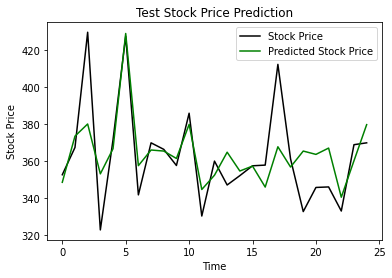

In [15]:
# Test Data Plotted
import matplotlib.pyplot as plt

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)     # To bring in original readable form
original_stock_price=sc.inverse_transform(y_test)
plt.plot(original_stock_price, color = 'black', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Test Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [16]:
for i in range(25):
  print("{0} ---- {1}".format(original_stock_price[i], predicted_stock_price[i]))

[352.7799988] ---- [348.69516]
[367.5] ---- [373.61142]
[429.6900024] ---- [380.1727]
[323.] ---- [353.25525]
[371.6700134] ---- [366.82678]
[427.5] ---- [429.0218]
[341.9100037] ---- [357.69476]
[370.] ---- [366.1282]
[366.4899902] ---- [365.56134]
[357.769989] ---- [361.56183]
[385.9899902] ---- [379.95093]
[330.5] ---- [344.8309]
[360.1400146] ---- [352.51685]
[347.25] ---- [364.94678]
[352.2999878] ---- [354.7917]
[357.6099854] ---- [357.45328]
[357.980011] ---- [346.12698]
[412.3500061] ---- [367.8813]
[361.2999878] ---- [356.94598]
[332.8900146] ---- [365.55618]
[345.9200134] ---- [363.7625]
[346.2000122] ---- [367.17313]
[333.1973877] ---- [340.6462]
[369.] ---- [360.33615]
[370.] ---- [379.81335]


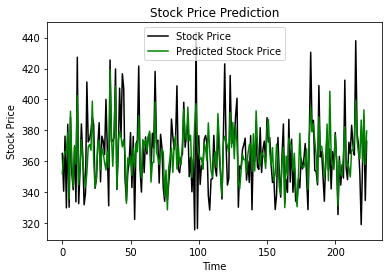

In [17]:

predicted_stock_price = model.predict(X_train)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
original_stock_price=sc.inverse_transform(y_train)
plt.plot(original_stock_price, color = 'black', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()